In [37]:
!pip install opendatasets --upgrade --quiet

In [38]:
import opendatasets

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
opendatasets.download(dataset_url)

Skipping, found downloaded files in "./animefacedataset" (use force=True to force download)


In [39]:
import os 

REL_DIR = './animefacedataset'
print(os.listdir(REL_DIR))

['images']


Let us see some examples from dataset

In [40]:
print(os.listdir('./animefacedataset/images')[:5])

['29257_2010.jpg', '24730_2009.jpg', '24189_2008.jpg', '34624_2011.jpg', '26417_2009.jpg']


In [41]:
!pip install torch

In [42]:
!pip install torchvision

In [43]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [44]:
image_size = 64
batch_size = 200
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [45]:
dataset_fixer = ImageFolder(REL_DIR, transform = T.Compose(
    [
        T.Resize(image_size),
        T.CenterCrop(image_size),
        T.ToTensor(),
        T.Normalize(*stats)
    ]
))

data_loader = DataLoader(dataset_fixer, batch_size, shuffle=True, num_workers=4)

In [46]:
!pip install matplotlib

In [47]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

Denormalizer is used to bring the image to the interval of [0,1].
NOTE: It was [-1, 1] initially.

In [48]:
def image_denormalizer(img_tensors):
  return img_tensors * stats[1][0] + stats[0][0]

See (16) samples from Anime Dataset.

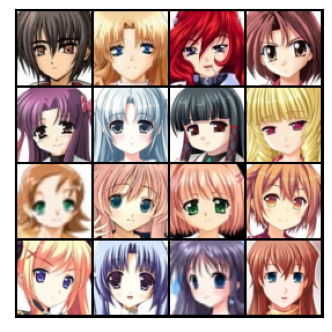

In [49]:
def show_images(img_tensors, num_of_printed=16):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(image_denormalizer(img_tensors.detach()[:num_of_printed]), nrow=4).permute(1, 2, 0))

for batch_images, _ in data_loader:
  show_images(batch_images, 16)
  break

We may want to use GPU (if available) or just CPU.

In [50]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

We move results to the specified device.

In [51]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    res = [to_device(i, device) for i in data]
    return res
  else:
    return data.to(device, non_blocking=True)

In [52]:
class DeviceDataLoader():
    def __init__(self, data_loader, device):
        self.data_loader = data_loader
        self.device = device
        
    def __iter__(self):
        for i in self.data_loader: 
            yield to_device(i, self.device)

    def __len__(self):
        return len(self.data_loader)

Check which device you are using.

In [53]:
device = get_default_device()
device

device(type='cpu')

Now, we can run below code to make sure that the whole data will be transferred to GPU if there is any. For instance, in my case, it will NOT be transferred to GPU since I am using only CPU right now.

In [54]:
data_loader = DeviceDataLoader(data_loader, device)

From now on, we will be creating Discriminator Network whose responsibility is to check whether the image comes from original source or it is artificially generated. Throughout the process, Discriminator will learn how to detect fake images better and better.

In [55]:
import torch.nn as nn

# output_shape = ((input_shape + 2 * padding - kernel_size)//stride) + 1

discriminator = nn.Sequential(
    # input shape: [64, 64, 3]
    nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.15, inplace=True),
    # shape: [32, 32, 128]

    # shape: [32, 32, 128]
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.15, inplace=True),
    # shape: [16, 16, 256]

    # shape: [16, 16, 256]
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # shape: [8, 8, 512]

    # shape: [8, 8, 512]
    nn.Conv2d(512, 10, kernel_size=4, stride=2, padding=0),
    # shape: [3, 3, 10]

    nn.Conv2d(10, 1, kernel_size=4, stride=2, padding=1),

    nn.Flatten(),
    nn.Sigmoid()
)

In [56]:
!pip install torchsummary

In [57]:
from torchsummary import summary

summary(discriminator, input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           6,272
       BatchNorm2d-2          [-1, 128, 32, 32]             256
         LeakyReLU-3          [-1, 128, 32, 32]               0
            Conv2d-4          [-1, 256, 16, 16]         524,544
       BatchNorm2d-5          [-1, 256, 16, 16]             512
         LeakyReLU-6          [-1, 256, 16, 16]               0
            Conv2d-7            [-1, 512, 8, 8]       2,097,664
       BatchNorm2d-8            [-1, 512, 8, 8]           1,024
         LeakyReLU-9            [-1, 512, 8, 8]               0
           Conv2d-10             [-1, 10, 3, 3]          81,930
           Conv2d-11              [-1, 1, 1, 1]             161
          Flatten-12                    [-1, 1]               0
          Sigmoid-13                    [-1, 1]               0
Total params: 2,712,363
Trainable param

Here, as the last layer activation, we have used Sigmoid but not Softmax. This is because we work only with 1 class.

In [58]:
discriminator = to_device(discriminator, device)

In [59]:
latent_size = 128

In [60]:
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 128, kernel_size=4, stride=1, padding=0),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.ConvTranspose2d(128, 256, kernel_size=4, stride=2, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
    nn.Tanh()
)

As can be seen, last output of deconvolution is in 3x64x64, which we want to get (RGB form).

In [61]:
summary(generator, input_size=(128, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 128, 4, 4]         262,272
       BatchNorm2d-2            [-1, 128, 4, 4]             256
              ReLU-3            [-1, 128, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]         524,544
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,416
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,136
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,075
             Tanh-14            [-1, 3,

In [62]:
generator = to_device(generator, device)

Now, we are generating some pictures from random numbers, it is very normal for pictures to random right now. After generative network (GN) is going to learn, it will print generative images better and better every time.

torch.Size([200, 3, 64, 64])


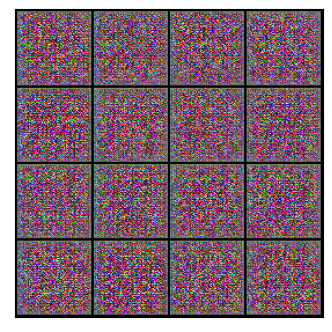

In [63]:
random_visualization = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(random_visualization)
print(fake_images.shape)
show_images(fake_images)

In [64]:
from torch.nn import functional

def discriminator_training(real_images, optimizer):
  optimizer.zero_grad()

  # Calculate loss after pushing real images to discriminator network
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device=device)
  real_loss = functional.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  # Create fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  # Calculate loss after pushing real images to discriminator network
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = functional.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  # BackPropagation and Updating weights of network
  loss = real_loss + fake_loss
  loss.backward()
  optimizer.step()

  return loss.item(), real_score, fake_score

In [65]:
def generator_training(optimizer):
  optimizer.zero_grad()
    
  # Generate fake images
  latent_vector = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent_vector)
    
  # Now, we will try to fool the discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = functional.binary_cross_entropy(preds, targets)
    
  # BackPropogation and learning to update generator weights
  loss.backward()
  optimizer.step()
    
  return loss.item()

We will save generated images after each iteration.

In [66]:
from torchvision.utils import save_image

os.makedirs('./generated_images', exist_ok=True)

def save_samples(index, latent_tensors, visualize=True):
    fake_images = generator(latent_tensors)
    fake_file = 'newly_generated_{0:0=4d}.png'.format(index)
    save_image(image_denormalizer(fake_images), os.path.join('./generated_images', fake_file), nrow=8)
    print('Saved image(s): ', fake_file)
    if visualize:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=4).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved image(s):  newly_generated_0000.png


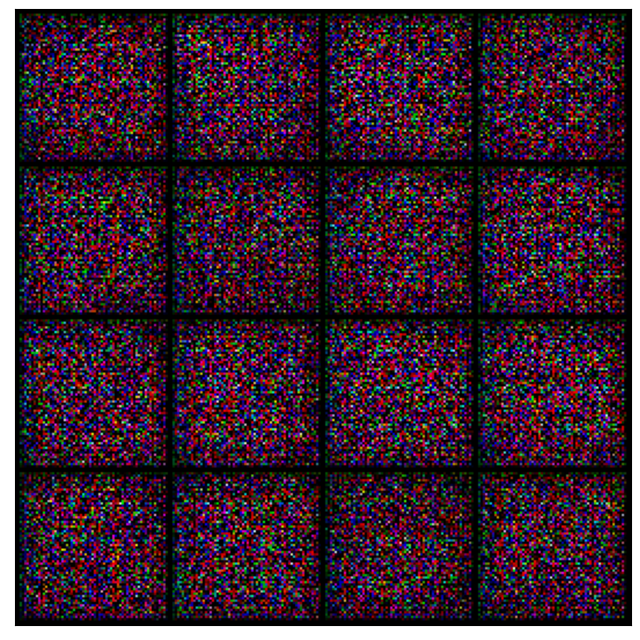

In [67]:
fake_images_each_step = torch.randn(16, latent_size, 1, 1, device=device)
save_samples(0, fake_images_each_step)

Now, it is time to train our models.

In [68]:
from tqdm.notebook import tqdm

def fit(epoch_size, learning_rate, start_index_for_generated_images=1):
    # torch.cuda.empty_cache()
    
    generation_losses = []
    discrimination_losses = []
    real_scores = []
    fake_scores = []
    
    optimizer_descriminator = torch.optim.Adam(discriminator.parameters(), learning_rate, betas=(0.5, 0.9))
    optimizar_generator = torch.optim.Adam(generator.parameters(), learning_rate, betas=(0.5, 0.9))
    
    for epoch in range(epoch_size):
        for real_images, _ in tqdm(data_loader):
            # Training discriminator
            discrimination_loss, real_score, fake_score = discriminator_training(real_images, optimizer_descriminator)
            # Training generator
            generation_loss = generator_training(optimizar_generator)
            
        # loss and score history
        generation_losses.append(generation_loss)
        discrimination_losses.append(discrimination_loss)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        print("Epoch [{}/{}], generator_loss: {:.4f}, generator_loss: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epoch_size, generation_loss, discrimination_loss, real_score, fake_score))
    
        # Saving generated images
        save_samples(epoch + start_index_for_generated_images, fake_images_each_step, visualize=False)
    
    return generation_losses, discrimination_losses, real_scores, fake_scores

Time to run!

In [69]:
model = fit(epoch_size = 20, learning_rate=0.001)

  0%|          | 0/318 [00:00<?, ?it/s]

Epoch [1/20], generator_loss: 5.3319, generator_loss: 0.5865, real_score: 0.7849, fake_score: 0.2308
Saved image(s):  newly_generated_0001.png


  0%|          | 0/318 [00:00<?, ?it/s]

Epoch [2/20], generator_loss: 5.9013, generator_loss: 0.7311, real_score: 0.8259, fake_score: 0.3513
Saved image(s):  newly_generated_0002.png


  0%|          | 0/318 [00:00<?, ?it/s]

Epoch [3/20], generator_loss: 4.0491, generator_loss: 0.6243, real_score: 0.6278, fake_score: 0.0349
Saved image(s):  newly_generated_0003.png


  0%|          | 0/318 [00:00<?, ?it/s]

Epoch [4/20], generator_loss: 8.0462, generator_loss: 0.5834, real_score: 0.8870, fake_score: 0.3305
Saved image(s):  newly_generated_0004.png


  0%|          | 0/318 [00:00<?, ?it/s]

Epoch [5/20], generator_loss: 4.8861, generator_loss: 0.4383, real_score: 0.7340, fake_score: 0.0427
Saved image(s):  newly_generated_0005.png


  0%|          | 0/318 [00:00<?, ?it/s]

Epoch [6/20], generator_loss: 7.3713, generator_loss: 0.3823, real_score: 0.9324, fake_score: 0.2287
Saved image(s):  newly_generated_0006.png


  0%|          | 0/318 [00:00<?, ?it/s]

Epoch [7/20], generator_loss: 1.5040, generator_loss: 0.6755, real_score: 0.6503, fake_score: 0.0266
Saved image(s):  newly_generated_0007.png


  0%|          | 0/318 [00:00<?, ?it/s]

Epoch [8/20], generator_loss: 8.6864, generator_loss: 0.4766, real_score: 0.7087, fake_score: 0.0013
Saved image(s):  newly_generated_0008.png


  0%|          | 0/318 [00:00<?, ?it/s]

Epoch [9/20], generator_loss: 5.8091, generator_loss: 0.2613, real_score: 0.8276, fake_score: 0.0196
Saved image(s):  newly_generated_0009.png


  0%|          | 0/318 [00:00<?, ?it/s]

Epoch [10/20], generator_loss: 4.3506, generator_loss: 0.1750, real_score: 0.9604, fake_score: 0.1063
Saved image(s):  newly_generated_0010.png


  0%|          | 0/318 [00:00<?, ?it/s]

Epoch [11/20], generator_loss: 6.7936, generator_loss: 0.2306, real_score: 0.9555, fake_score: 0.1476
Saved image(s):  newly_generated_0011.png


  0%|          | 0/318 [00:00<?, ?it/s]

Epoch [12/20], generator_loss: 7.3799, generator_loss: 0.3724, real_score: 0.7957, fake_score: 0.0041
Saved image(s):  newly_generated_0012.png


  0%|          | 0/318 [00:00<?, ?it/s]

Epoch [13/20], generator_loss: 9.2824, generator_loss: 0.0991, real_score: 0.9284, fake_score: 0.0063
Saved image(s):  newly_generated_0013.png


  0%|          | 0/318 [00:00<?, ?it/s]

Epoch [14/20], generator_loss: 3.1379, generator_loss: 0.1337, real_score: 0.9782, fake_score: 0.0885
Saved image(s):  newly_generated_0014.png


  0%|          | 0/318 [00:00<?, ?it/s]

Epoch [15/20], generator_loss: 9.7719, generator_loss: 0.3650, real_score: 0.9569, fake_score: 0.2372
Saved image(s):  newly_generated_0015.png


  0%|          | 0/318 [00:00<?, ?it/s]

Epoch [16/20], generator_loss: 7.9666, generator_loss: 0.1896, real_score: 0.9386, fake_score: 0.0947
Saved image(s):  newly_generated_0016.png


  0%|          | 0/318 [00:00<?, ?it/s]

Epoch [17/20], generator_loss: 8.9487, generator_loss: 0.1671, real_score: 0.9175, fake_score: 0.0464
Saved image(s):  newly_generated_0017.png


  0%|          | 0/318 [00:00<?, ?it/s]

Epoch [18/20], generator_loss: 12.7497, generator_loss: 0.0661, real_score: 0.9482, fake_score: 0.0005
Saved image(s):  newly_generated_0018.png


  0%|          | 0/318 [00:00<?, ?it/s]

Epoch [19/20], generator_loss: 7.2753, generator_loss: 0.2664, real_score: 0.9318, fake_score: 0.1259
Saved image(s):  newly_generated_0019.png


  0%|          | 0/318 [00:00<?, ?it/s]

Epoch [20/20], generator_loss: 7.4139, generator_loss: 0.1531, real_score: 0.9670, fake_score: 0.0939
Saved image(s):  newly_generated_0020.png


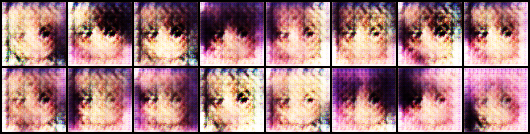

In [72]:
from IPython.display import Image

Image('./generated_images/newly_generated_0001.png')

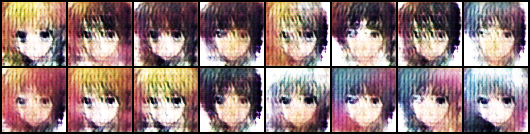

In [73]:
Image('./generated_images/newly_generated_0003.png')

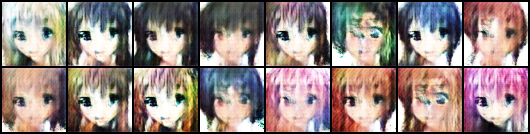

In [74]:
Image('./generated_images/newly_generated_0007.png')

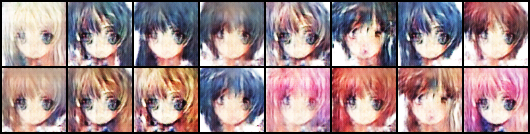

In [75]:
Image('./generated_images/newly_generated_0010.png')

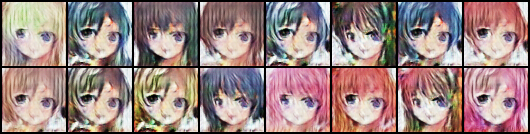

In [76]:
Image('./generated_images/newly_generated_0016.png')

Graph Visualizations

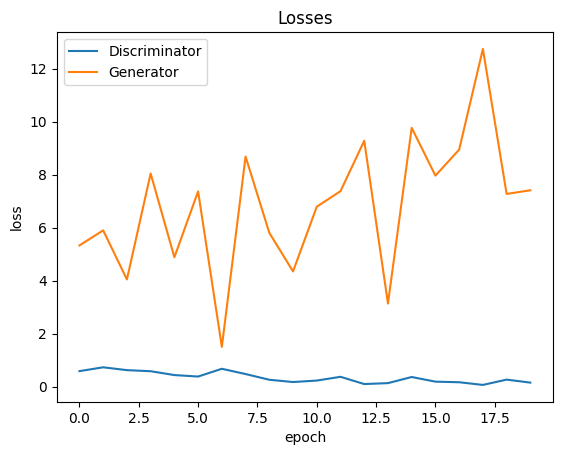

In [98]:
gl, dl, rs, fs = model

plt.plot(dl, '-')
plt.plot(gl, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

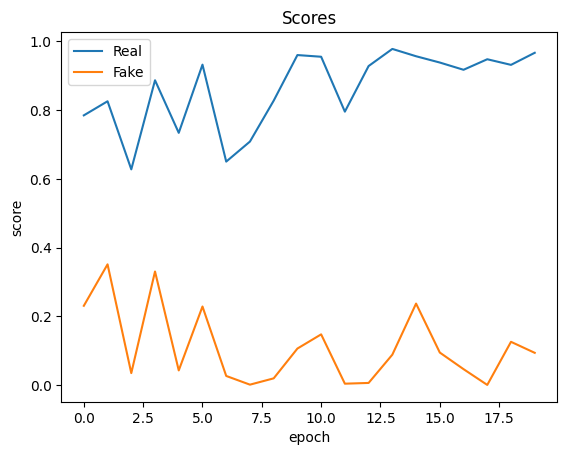

In [99]:
plt.plot(rs, '-')
plt.plot(fs, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

As can be seen, mostly Real scores is going to increase, and fake scores is going to decrease, which is something that we want to achieve.